# 2: Managerial Approach to Customer Segmentation

This notebook will go through the understanding of customer segmentation, a key concept in the field of customer analytics, using Python data science tools.

Customer segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately. In the world of marketing, the practice of dividing the market into identifiable segments having common needs, or characteristics is a common practice. This helps the businesses to develop marketing programs that are most effective for each segment.

This notebook offers a robust and hands-on exploration of customer segmentation using a managerial approach. The process is broken down into easy-to-understand steps, and you'll have the opportunity to work with real-world data, manipulate and visualize the data, and draw actionable insights that could be potentially used to drive business decisions.

## Notebook Overview

This notebook is divided into several sections, each of which explores an important aspect of customer segmentation.

1. **Data Loading and Preparation**: We start by loading the necessary Python libraries and the dataset. The data used in this notebook is a real-world dataset that contains information about customers' purchase history.

2. **Data Exploration and Visualization**: In this section, we get a sense of the data by visualizing it. This step is critical in understanding underlying patterns, outliers, and other characteristics of the data.

3. **Creating RFM (Recency, Frequency, Monetary) Based Statistics**: RFM is a method used for analyzing customer value. We create these RFM statistics based on the dataset.

4. **Customer Segmentation**: We create different segments of customers based on their RFM statistics. Segmentation can be done in many ways. In this notebook, we demonstrate simple segmentation based on recency alone, and more complex multi-segment segmentation.

5. **Retrospective Analysis**: In this advanced step, we perform a retrospective analysis by creating a function that can generate customer segmentation for any given historical moment.

The main libraries used in this notebook are pandas for data manipulation, matplotlib for data visualization, and scikit-learn for data preprocessing and clustering.

## Learning Outcomes

By the end of this notebook, we will have a good understanding of how to:

- Load and manipulate data for customer segmentation using pandas.
- Visualize data using matplotlib.
- Understand the concept of RFM (Recency, Frequency, Monetary) in the context of customer segmentation.
- Use segmentation to categorize customers into different groups.
- Perform retrospective analysis to understand customer behavior over time.

In [46]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

## Load and Visualize Dataset

In [3]:
df = pd.read_csv(
    'raw_orders.txt',
    header=None,sep='\t',
    parse_dates=[2],
    names=['customer_id','purchase_amount','date_of_purchase'])
df['year_of_purchase'] = df.date_of_purchase.dt.year
df.head(5)

,customer_id,purchase_amount,date_of_purchase,year_of_purchase
0,760,25.0,2009-11-06,2009
1,860,50.0,2012-09-28,2012
2,1200,100.0,2005-10-25,2005
3,1420,50.0,2009-07-09,2009
4,1940,70.0,2013-01-25,2013


## Create RFM (Recency Frequency Money) Based Statistics

In [4]:
df['days_since'] = (df.date_of_purchase.max() - df.date_of_purchase).dt.days + 1
g = df.groupby(by="customer_id")
customers_2015 = pd.DataFrame({
    'recency' : g.days_since.min(), 
    'first_purchase' : g.days_since.max(),
    'frequency' : g.days_since.count(), 
    'amount' : g.purchase_amount.mean()}, 
    columns= ['recency','first_purchase','frequency','amount']
    )

In [5]:
customers_2015.describe()

,recency,first_purchase,frequency,amount
count,18417.000000,18417.000000,18417.000000,18417.000000
mean,1253.037900,1984.009882,2.782375,57.792985
std,1081.437868,1133.405441,2.936888,154.360109
min,1.000000,1.000000,1.000000,5.000000
25%,244.000000,988.000000,1.000000,21.666667
50%,1070.000000,2087.000000,2.000000,30.000000
75%,2130.000000,2992.000000,3.000000,50.000000
max,4014.000000,4016.000000,45.000000,4500.000000


### Simple 2-segment solution based upon recency alone

In [6]:
customers_2015['segment'] = np.where(customers_2015.recency > 365*3, 'inactive', 'active')
customers_2015.segment.value_counts()

active      9259
inactive    9158
Name: segment, dtype: int64

In [7]:
customers_2015.groupby(by='segment').mean()

,recency,first_purchase,frequency,amount
segment,,,,
active,338.055946,1427.983584,3.739713,67.367605
inactive,2178.110832,2546.168377,1.814479,48.112771


### Simple multi-segment segmentation

In [8]:
customers_2015['segment'] = 'NA'
customers_2015.loc[customers_2015.recency > 365*3,'segment'] = 'inactive'
customers_2015.loc[(customers_2015.recency <= 365*3) & (customers_2015.recency > 365*2),'segment'] = 'cold'
customers_2015.loc[(customers_2015.recency <= 365*2) & (customers_2015.recency > 365*1),'segment'] = 'warm'
customers_2015.loc[customers_2015.recency <= 365*1,'segment'] = 'active'
customers_2015.segment.value_counts()

inactive    9158
active      5398
warm        1958
cold        1903
Name: segment, dtype: int64

In [9]:
customers_2015.groupby(by='segment').mean()

,recency,first_purchase,frequency,amount
segment,,,,
active,99.740645,1465.843461,4.560763,72.080944
cold,857.781398,1432.117183,2.303205,51.739893
inactive,2178.110832,2546.168377,1.814479,48.112771
warm,489.939734,1319.590398,2.872319,69.562155


### Actual segmentation

In [10]:
def segment(customers):
    customers['segment'] = 'NA'
    # segment by recency
    customers.loc[customers.recency > 365*3,'segment'] = 'inactive'
    customers.loc[(customers.recency <= 365*3) & (customers.recency > 365*2),'segment'] = 'cold'
    customers.loc[(customers.recency <= 365*2) & (customers.recency > 365*1),'segment'] = 'warm'
    customers.loc[customers.recency <= 365*1,'segment'] = 'active'
    # segment warm into (new, low value, high value)
    customers.loc[(customers.segment == 'warm') & (customers.first_purchase <= 365*2),'segment'] = 'new warm'
    customers.loc[(customers.segment == 'warm') & (customers.amount < 100),'segment'] = 'warm low value'
    customers.loc[(customers.segment == 'warm') & (customers.amount >= 100),'segment'] = 'warm high value'
    # segment active into (new, low value, high value)
    customers.loc[(customers.segment == 'active') & (customers.first_purchase <= 365),'segment'] = 'new active'
    customers.loc[(customers.segment == 'active') & (customers.amount < 100),'segment'] = 'active low value'
    customers.loc[(customers.segment == 'active') & (customers.amount >= 100),'segment'] = 'active high value'
    customers.segment = order_segments(customers.segment)
    customers
    return customers

def order_segments(s):
    return s.astype("category", categories=[
        "inactive",
        "cold",
        "warm high value", "warm low value","new warm",
        "active high value", "active low value", "new active"
        ],ordered=True)

In [11]:
segment(customers_2015)
customers_2015.groupby(by='segment').segment.count()

segment
inactive             9158
cold                 1903
warm high value       119
warm low value        901
new warm              938
active high value     573
active low value     3313
new active           1512
Name: segment, dtype: int64

In [12]:
customers_2015.groupby(by='segment').mean()

,recency,first_purchase,frequency,amount
segment,,,,
inactive,2178.110832,2546.168377,1.814479,48.112771
cold,857.781398,1432.117183,2.303205,51.739893
warm high value,455.126050,2015.352941,4.714286,327.407457
warm low value,474.377358,2063.639290,4.531632,38.591926
new warm,509.304904,516.622601,1.044776,66.599026
active high value,88.820244,1985.909250,5.888307,240.045740
active low value,108.361002,2003.801992,5.935406,40.724525
new active,84.990741,90.013889,1.045635,77.133847


## Retrospective Segmentation

In [13]:
years = np.sort(df.date_of_purchase.dt.year.unique())
retro_dates = pd.to_datetime(years + 1,format="%Y")
retro_dates

DatetimeIndex(['2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', freq=None)

In [14]:
def retro(sales_data,retrospective_date):
    retro_sales_data = sales_data[sales_data.date_of_purchase < retrospective_date].copy()
    retro_sales_data['days_since'] = (retrospective_date - retro_sales_data.date_of_purchase).dt.days
    return retro_sales_data

def rfm(sales_data,year=None):
    g = sales_data.groupby(by='customer_id')
    df = pd.DataFrame({
        'recency' : g.days_since.min(), 
        'first_purchase' : g.days_since.max(),
        'frequency' : g.days_since.count(), 
        'amount' : g.purchase_amount.mean()}, 
        columns= ['recency','first_purchase','frequency','amount'])
    if year:
        df['year'] = year
    return df

In [15]:
retro(df,pd.to_datetime('2010')).head()

,customer_id,purchase_amount,date_of_purchase,year_of_purchase,days_since
0,760,25.0,2009-11-06,2009,56
2,1200,100.0,2005-10-25,2005,1529
3,1420,50.0,2009-07-09,2009,176
6,2620,30.0,2006-03-09,2006,1394
7,3050,50.0,2007-04-12,2007,995


In [16]:
rfm(retro(df,pd.to_datetime('2010'))).head()

,recency,first_purchase,frequency,amount
customer_id,,,,
10,1638,1638,1,30.0
80,266,1560,3,60.0
90,72,1592,5,135.6
130,779,1519,2,50.0
160,772,1386,2,30.0


In [17]:
customers = pd.concat([rfm(retro(df,date),date.year - 1) for date in retro_dates])
customers.set_index('year',append=True,inplace=True)
customers.sort_index(inplace=True)
customers.head(22)

recency  first_purchase  frequency     amount
customer_id year                                               
10          2005      177             177          1  30.000000
            2006      542             542          1  30.000000
            2007      907             907          1  30.000000
            2008     1273            1273          1  30.000000
            2009     1638            1638          1  30.000000
            2010     2003            2003          1  30.000000
            2011     2368            2368          1  30.000000
            2012     2734            2734          1  30.000000
            2013     3099            3099          1  30.000000
            2014     3464            3464          1  30.000000
            2015     3829            3829          1  30.000000
80          2005       99              99          1  50.000000
            2006      464             464          1  50.000000
            2007      258             829          2  55.000000
            2008      624            1195          2  55.000000
            2009      266            1560          3  60.000000
            2010      631            1925          3  60.000000
            2011      149            2290          4  65.000000
            2012      515            2656          4  65.000000
            2013      147            3021          5  68.000000
            2014      302            3386          6  70.000000
            2015      343            3751          7  71.428571

In [18]:
customers = segment(customers)
customers.head(22)

recency  first_purchase  frequency     amount  \
customer_id year                                                  
10          2005      177             177          1  30.000000   
            2006      542             542          1  30.000000   
            2007      907             907          1  30.000000   
            2008     1273            1273          1  30.000000   
            2009     1638            1638          1  30.000000   
            2010     2003            2003          1  30.000000   
            2011     2368            2368          1  30.000000   
            2012     2734            2734          1  30.000000   
            2013     3099            3099          1  30.000000   
            2014     3464            3464          1  30.000000   
            2015     3829            3829          1  30.000000   
80          2005       99              99          1  50.000000   
            2006      464             464          1  50.000000   
            2007      258             829          2  55.000000   
            2008      624            1195          2  55.000000   
            2009      266            1560          3  60.000000   
            2010      631            1925          3  60.000000   
            2011      149            2290          4  65.000000   
            2012      515            2656          4  65.000000   
            2013      147            3021          5  68.000000   
            2014      302            3386          6  70.000000   
            2015      343            3751          7  71.428571   

                           segment  
customer_id year                    
10          2005        new active  
            2006          new warm  
            2007              cold  
            2008          inactive  
            2009          inactive  
            2010          inactive  
            2011          inactive  
            2012          inactive  
            2013          inactive  
            2014          inactive  
            2015          inactive  
80          2005        new active  
            2006          new warm  
            2007  active low value  
            2008    warm low value  
            2009  active low value  
            2010    warm low value  
            2011  active low value  
            2012    warm low value  
            2013  active low value  
            2014  active low value  
            2015  active low value

In [19]:
customers.segment.unstack('year').head(6)

year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
customer_id,,,,,,,,,,,
10,new active,new warm,cold,inactive,inactive,inactive,inactive,inactive,inactive,inactive,inactive
80,new active,new warm,active low value,warm low value,active low value,warm low value,active low value,warm low value,active low value,active low value,active low value
90,new active,active high value,active high value,active high value,active high value,active high value,active high value,active high value,active high value,warm high value,cold
120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,new active,new warm,cold,inactive
130,new active,new warm,active low value,warm low value,cold,inactive,inactive,inactive,inactive,inactive,inactive
160,NaN,new active,active low value,warm low value,cold,inactive,inactive,inactive,inactive,inactive,inactive


In [20]:
customers.xs(120,level=0)

,recency,first_purchase,frequency,amount,segment
year,,,,,
2012,306,306,1,20.0,new active
2013,671,671,1,20.0,new warm
2014,1036,1036,1,20.0,cold
2015,1401,1401,1,20.0,inactive


In [21]:
idx = pd.IndexSlice
customers.xs(2014,level='year').groupby(by='segment').mean()

,recency,first_purchase,frequency,amount
segment,,,,
inactive,2058.441294,2353.036874,1.730964,48.111199
cold,866.616814,1565.444032,2.254064,51.114605
warm high value,461.198198,1878.810811,4.414414,187.849110
warm low value,470.661088,1945.426778,4.361925,37.382060
new warm,497.317600,504.880000,1.057600,51.367653
active high value,85.338947,1838.050526,5.696842,261.902155
active low value,98.091000,1796.351378,5.633677,40.459174
new active,132.086987,142.871260,1.070981,69.725159


In [22]:
segmentation_by_year = customers.segment.unstack('year')
cust_segs_2014 = segmentation_by_year[2014]
cust_segs_2015 = segmentation_by_year[2015]
pd.crosstab(index=cust_segs_2015,columns=cust_segs_2014,margins=True)

2014,inactive,cold,warm high value,warm low value,new warm,active high value,active low value,new active,All
2015,,,,,,,,,
inactive,7227,1931,0,0,0,0,0,0,9158
cold,0,0,75,689,1139,0,0,0,1903
warm high value,0,0,0,0,0,119,0,0,119
warm low value,0,0,0,0,0,0,901,0,901
new warm,0,0,0,0,0,0,0,938,938
active high value,35,22,35,1,15,354,22,89,573
active low value,250,200,1,266,96,2,2088,410,3313
new active,0,0,0,0,0,0,0,0,0
All,7512,2153,111,956,1250,475,3011,1437,16905


In [23]:
ct = pd.crosstab(index=cust_segs_2015,columns=cust_segs_2014,normalize='all',margins=True)
ct

2014,inactive,cold,warm high value,warm low value,new warm,active high value,active low value,new active,All
2015,,,,,,,,,
inactive,0.427507,0.114227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.541733
cold,0.000000,0.000000,0.004437,0.040757,0.067377,0.000000,0.000000,0.000000,0.112570
warm high value,0.000000,0.000000,0.000000,0.000000,0.000000,0.007039,0.000000,0.000000,0.007039
warm low value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053298,0.000000,0.053298
new warm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055487,0.055487
active high value,0.002070,0.001301,0.002070,0.000059,0.000887,0.020941,0.001301,0.005265,0.033895
active low value,0.014789,0.011831,0.000059,0.015735,0.005679,0.000118,0.123514,0.024253,0.195978
new active,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
All,0.444366,0.127359,0.006566,0.056551,0.073943,0.028098,0.178113,0.085004,1.000000


In [31]:
%qtconsole

<IPython.core.display.Javascript object>


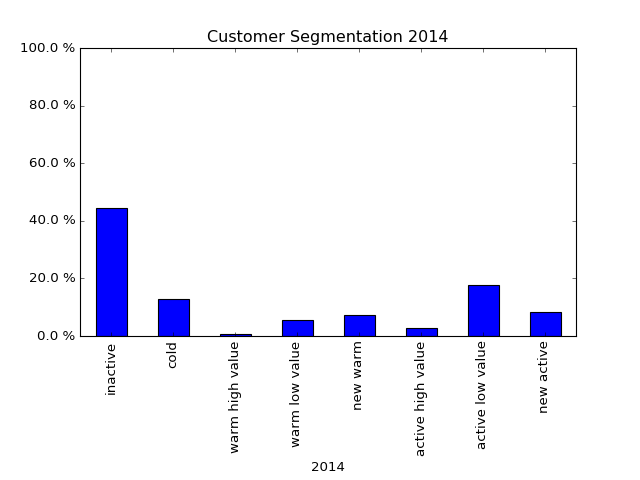

In [38]:
from matplotlib.ticker import FuncFormatter
plt.figure().subplots_adjust(bottom=.3)
formatter = FuncFormatter(lambda y, pos: str(100*y) + ' %')
plt.gca().yaxis.set_major_formatter(formatter)
ct.ix['All',:-1].plot(kind='bar',ylim=[0.0,1.0],title="Customer Segmentation 2014")

### Segments and Revenue Generation

In [40]:
revenue = df.groupby(by=['customer_id','year_of_purchase']).purchase_amount.sum()
revenue.name = "revenue"
revenue.index.set_names(['customer_id','year'],inplace=True)
if 'revenue' in customers.columns:
    customers.drop(['revenue'],axis=1,inplace=True)
customers = customers.join(revenue)
customers.revenue.fillna(0,inplace=True)
customers.head(22)

recency  first_purchase  frequency     amount  \
customer_id year                                                  
10          2005      177             177          1  30.000000   
            2006      542             542          1  30.000000   
            2007      907             907          1  30.000000   
            2008     1273            1273          1  30.000000   
            2009     1638            1638          1  30.000000   
            2010     2003            2003          1  30.000000   
            2011     2368            2368          1  30.000000   
            2012     2734            2734          1  30.000000   
            2013     3099            3099          1  30.000000   
            2014     3464            3464          1  30.000000   
            2015     3829            3829          1  30.000000   
80          2005       99              99          1  50.000000   
            2006      464             464          1  50.000000   
            2007      258             829          2  55.000000   
            2008      624            1195          2  55.000000   
            2009      266            1560          3  60.000000   
            2010      631            1925          3  60.000000   
            2011      149            2290          4  65.000000   
            2012      515            2656          4  65.000000   
            2013      147            3021          5  68.000000   
            2014      302            3386          6  70.000000   
            2015      343            3751          7  71.428571   

                           segment  revenue  
customer_id year                             
10          2005        new active     30.0  
            2006          new warm      0.0  
            2007              cold      0.0  
            2008          inactive      0.0  
            2009          inactive      0.0  
            2010          inactive      0.0  
            2011          inactive      0.0  
            2012          inactive      0.0  
            2013          inactive      0.0  
            2014          inactive      0.0  
            2015          inactive      0.0  
80          2005        new active     50.0  
            2006          new warm      0.0  
            2007  active low value     60.0  
            2008    warm low value      0.0  
            2009  active low value     70.0  
            2010    warm low value      0.0  
            2011  active low value     80.0  
            2012    warm low value      0.0  
            2013  active low value     80.0  
            2014  active low value     80.0  
            2015  active low value     80.0

#### Revenue in 2015 by Segment

In [41]:
customers_2015 = customers.loc[idx[:,2015],:]
customers_2015.groupby(by=['segment']).revenue.mean()

segment
inactive               0.000000
cold                   0.000000
warm high value        0.000000
warm low value         0.000000
new warm               0.000000
active high value    323.568935
active low value      52.306043
new active            79.166144
Name: revenue, dtype: float64

#### Projected Average Revenue By Segement

In [42]:
next_years_revenue = customers.revenue.groupby(level='customer_id').shift(-1)
next_years_revenue.name = 'next_years_revenue'
if 'next_years_revenue' in customers.columns:
    customers.drop(['next_years_revenue'],axis=1,inplace=True)
customers = customers.join(next_years_revenue)

In [43]:
customers_2014 = customers.loc[idx[:,2014],:]
expected_revenue = customers_2014.groupby(by='segment').next_years_revenue.mean()
expected_revenue

segment
inactive               2.949466
cold                   6.108221
warm high value      114.459459
warm low value        13.494770
new warm               5.064000
active high value    254.077895
active low value      41.896556
new active            31.046625
Name: next_years_revenue, dtype: float64

In [44]:
expected_revenue.sort_values(ascending=False)

segment
active high value    254.077895
warm high value      114.459459
active low value      41.896556
new active            31.046625
warm low value        13.494770
cold                   6.108221
new warm               5.064000
inactive               2.949466
Name: next_years_revenue, dtype: float64

<IPython.core.display.Javascript object>


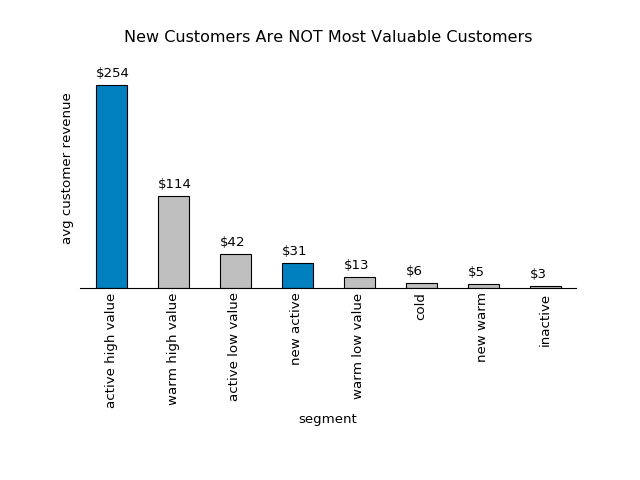

In [105]:
fig = plt.figure()
fig.subplots_adjust(bottom=.4)

my_colors = [(0.75, 0.75, 0.75)] * len(expected_revenue)
my_colors[0] = (0.0,0.5,0.75)
my_colors[3] = (0.0,0.5,0.75)
ax = expected_revenue.sort_values(ascending=False).plot.bar(
    title="New Customers Are NOT Most Valuable Customers",
    color=my_colors)
ax.set_ylabel('avg customer revenue')
plt.tick_params(
    axis='both', 
    which='both', 
    bottom='off', 
    top='off', 
    labelbottom='on', 
    right='off', 
    left='on', labelleft='off')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none')
for p in ax.patches:
    value = '$' + str(np.round(p.get_height()).astype(int))
    ax.annotate(value, xy=(p.get_x(), p.get_height()+ 10))